## Prueba de Modelización de territorio con regresión lineal en Sagemaker

En este modelo reproducimos el formato de la modelización sin PCA en sagemaker, para comparar estimaciones. 

Utilizamos una vez más un contenedor con una imagen de modelo facilitada por AWS, creemos que ahí está la clave de no obtener mejoras, tras consultar con personas que utilizan SM a diario laboralmente, nos confirman que las mejoras más claras vienen cuando se utilizan los modelos propios mediante imagen de docker. (versión 2). 

Como en el modelo elaborado en local, la modelización la haremos mediante regresión lineal sin utilizar PCA.

Primero elegimos las secciones para una misma elección, en este caso la de noviembre de 2019. Después tomamos las secciones elegidas y utilizamos sus equivalentes de las elecciones de 2016, para ver si sirven para modelizar la provincia de Zaragoza en esos comicios.

## Modelización en las elecciones de noviembre de 2019

Comenzamos cargando las librerías necesarias, así como el dataset de las elecciones de noviembre de 2019.

In [9]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import sklearn.model_selection
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
session = sagemaker.Session()
role = get_execution_role()

In [10]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str', 'cod_sec' : 'str'}

In [11]:
bucket_name = 'arn:aws:s3:::electomedia' 
prefix= 'reg'
file_key = 'datos-elecciones-generales-unificados/gen_N19_unif_cols_prov_copia.txt'
s3uri = 's3://electomedia/datos-elecciones-generales-unificados/gen_N19_unif_cols_prov_copia.txt'
df_eleccion = pd.read_csv(s3uri)


In [12]:
df_eleccion.head()

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,...,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019111010400101001,1,4,4001,400101001,Andalucía,Almería,Abla,1002,717,...,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 193, 'PSOE': 310, 'Cs': 47, 'UP': 30, '...","[('PSOE', 310), ('PP', 193), ('VOX', 122), ('C..."
1,022019111010400201001,1,4,4002,400201001,Andalucía,Almería,Abrucena,1013,711,...,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 111, 'PSOE': 349, 'Cs': 45, 'UP': 42, '...","[('PSOE', 349), ('VOX', 147), ('PP', 111), ('C..."
2,022019111010400301001,1,4,4003,400301001,Andalucía,Almería,Adra,667,484,...,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 176, 'PSOE': 128, 'Cs': 15, 'UP': 34, '...","[('PP', 176), ('PSOE', 128), ('VOX', 116), ('U..."
3,022019111010400301002,1,4,4003,400301002,Andalucía,Almería,Adra,1306,909,...,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 251, 'PSOE': 220, 'Cs': 51, 'UP': 58, '...","[('VOX', 312), ('PP', 251), ('PSOE', 220), ('U..."
4,022019111010400301003,1,4,4003,400301003,Andalucía,Almería,Adra,1551,975,...,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 292, 'PSOE': 202, 'Cs': 73, 'UP': 52, '...","[('VOX', 327), ('PP', 292), ('PSOE', 202), ('C..."


Primero especificamos el territorio que queremos modelizar, en este caso la provincia de Zaragoza. Dejamos vacías las opciones de CCAA y municipio; ambas deben ser cocurrentes, es decir, si escogiésemos un municipio, éste tendría que pertenecer en esta caso a la provincia de Zaragoza.

In [13]:
ccaa_mod = []

provincia_mod = ['Zaragoza']

municipio_mod = []

secciones_mod = df_eleccion

In [14]:
if len(ccaa_mod) > 0:

  secciones_mod = secciones_mod.loc[secciones_mod['CCAA'].isin(ccaa_mod)]

if len(provincia_mod) > 0:

  secciones_mod = secciones_mod.loc[secciones_mod['Provincia'].isin(provincia_mod)]

if len(municipio_mod) > 0:

  secciones_mod = secciones_mod.loc[secciones_mod['Municipio'].isin(municipio_mod)]



Vemos que tenemos 880 secciones electorales en Zaragoza provincia.

In [15]:
secciones_mod

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,...,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
6553,022019111025000101001,2,50,50001,5000101001,Aragón,Zaragoza,Abanto,89,68,...,28322.021999,21149.000000,7855.336603,5134.000000,3217.875711,4987.000000,293.331625,139.000000,"{'PP': 42, 'PSOE': 13, 'Cs': 1, 'UP': 0, 'IU':...","[('PP', 42), ('PSOE', 13), ('VOX', 10), ('MP',..."
6554,022019111025000201001,2,50,50002,5000201001,Aragón,Zaragoza,Acered,125,91,...,18895.000000,20525.000000,3494.000000,2873.000000,4611.000000,3968.000000,84.000000,233.000000,"{'PP': 43, 'PSOE': 19, 'Cs': 4, 'UP': 0, 'IU':...","[('PP', 43), ('VOX', 20), ('PSOE', 19), ('Cs',..."
6555,022019111025000301001,2,50,50003,5000301001,Aragón,Zaragoza,Agón,117,89,...,27578.000000,27753.000000,5804.000000,5694.000000,5604.000000,5250.000000,161.000000,247.000000,"{'PP': 23, 'PSOE': 39, 'Cs': 2, 'UP': 2, 'IU':...","[('PSOE', 39), ('PP', 23), ('VOX', 20), ('Cs',..."
6556,022019111025000401001,2,50,50004,5000401001,Aragón,Zaragoza,Aguarón,475,360,...,25421.000000,23879.000000,7039.000000,6056.000000,3502.000000,3246.000000,208.000000,253.000000,"{'PP': 96, 'PSOE': 155, 'Cs': 17, 'UP': 19, 'I...","[('PSOE', 155), ('PP', 96), ('VOX', 44), ('MP'..."
6557,022019111025000501001,2,50,50005,5000501001,Aragón,Zaragoza,Aguilón,228,185,...,31410.000000,29687.000000,8651.000000,8019.000000,5616.000000,4816.000000,108.000000,191.000000,"{'PP': 84, 'PSOE': 34, 'Cs': 13, 'UP': 12, 'IU...","[('PP', 84), ('VOX', 35), ('PSOE', 34), ('Cs',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,022019111025029802001,2,50,50298,5029802001,Aragón,Zaragoza,Zuera,610,482,...,31542.000000,31419.000000,9774.000000,8326.000000,3118.000000,3365.000000,213.000000,395.000000,"{'PP': 134, 'PSOE': 139, 'Cs': 45, 'UP': 50, '...","[('PSOE', 139), ('PP', 134), ('VOX', 82), ('UP..."
7429,022019111025090101001,2,50,50901,5090101001,Aragón,Zaragoza,Biel,133,96,...,25367.000000,26506.000000,13108.000000,9636.000000,7146.000000,7398.000000,145.000000,214.000000,"{'PP': 18, 'PSOE': 33, 'Cs': 7, 'UP': 8, 'IU':...","[('PSOE', 33), ('VOX', 21), ('PP', 18), ('UP',..."
7430,022019111025090201001,2,50,50902,5090201001,Aragón,Zaragoza,Marracos,77,65,...,28322.021999,26938.114416,7855.336603,6845.948425,3217.875711,2985.302533,293.331625,347.217589,"{'PP': 29, 'PSOE': 15, 'Cs': 4, 'UP': 3, 'IU':...","[('PP', 29), ('PSOE', 15), ('VOX', 10), ('Cs',..."
7431,022019111025090301001,2,50,50903,5090301001,Aragón,Zaragoza,Villamayor de Gállego,1143,844,...,34050.000000,31945.000000,9707.000000,8721.000000,3872.000000,3239.000000,162.000000,287.000000,"{'PP': 160, 'PSOE': 226, 'Cs': 64, 'UP': 133, ...","[('PSOE', 226), ('PP', 160), ('VOX', 160), ('U..."


Queremos modelizar solo los resultados electorales, por lo que nos quedamos solo con ellos.

In [16]:
secciones_mod_lista = list(secciones_mod['Sección']) 

In [17]:
cols_validas_mod = ['Censo_Esc', 'Votos_Total', 'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros']

In [18]:
secciones_mod = secciones_mod[cols_validas_mod]

In [19]:
secciones_mod

,Censo_Esc,Votos_Total,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,...,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros
6553,89,68,0,68,0,68,42,13,1,0,...,0,0,0,0,0,0,0,0,0,0
6554,125,91,5,86,0,86,43,19,4,0,...,0,0,0,0,0,0,0,0,0,0
6555,117,89,0,89,1,88,23,39,2,2,...,0,0,0,0,0,0,0,0,0,0
6556,475,360,4,356,2,354,96,155,17,19,...,0,0,0,0,0,0,0,0,0,2
6557,228,185,1,184,2,182,84,34,13,12,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,610,482,2,480,3,477,134,139,45,50,...,0,0,0,0,0,0,0,0,0,13
7429,133,96,0,96,0,96,18,33,7,8,...,0,0,0,0,0,0,0,0,0,2
7430,77,65,3,62,0,62,29,15,4,3,...,0,0,0,0,0,0,0,0,0,0
7431,1143,844,5,839,10,829,160,226,64,133,...,0,0,0,0,0,0,0,0,4,17


Ahora hay que obtener los resultados electorales conjunto del territorio que debemos modelizar. Primero nos quedamos con el censo del territorio, después creamos un df con estos resultados, y finalmente, muy importante: normalizamos estos resultados dividendo por el censo, así no importa el tamaño del territorio que queramos modelizar.

In [20]:
censo_mod = secciones_mod['Censo_Esc'].sum()

In [21]:
modelizacion = pd.DataFrame(secciones_mod.sum(), columns = ['Modelización'])

In [22]:
modelizacion['Modelización'] = modelizacion['Modelización'] / modelizacion['Modelización']['Censo_Esc']

Obtenemos un df de una columna con los resultados electorales normalizados por su censo.

In [23]:
modelizacion

,Modelización
Censo_Esc,1.000000
Votos_Total,0.719466
Nulos,0.006076
Votos_Válidos,0.713389
Blanco,0.006958
V_Cand,0.706431
PP,0.166932
PSOE,0.220048
Cs,0.065202
UP,0.080233


La primera fila siempre será 1, pues es el censo dividido por sí mismo, por lo que la podemos eliminar.

In [24]:
modelizacion = modelizacion.drop(['Censo_Esc']) 

In [25]:
modelizacion

,Modelización
Votos_Total,0.719466
Nulos,0.006076
Votos_Válidos,0.713389
Blanco,0.006958
V_Cand,0.706431
PP,0.166932
PSOE,0.220048
Cs,0.065202
UP,0.080233
IU,0.000000


In [26]:
modelizacion.shape

(30, 1)

Ahora debemos buscar las secciones que modelicen la provincia de Zaragoza, ella misma.

In [27]:
ccaa_select = []

provincia_select = ['Zaragoza']

municipio_select = []

secciones_select = df_eleccion

In [28]:
if len(ccaa_select) > 0:

  secciones_select = secciones_select.loc[secciones_select['CCAA'].isin(ccaa_select)]

if len(provincia_select) > 0:

  secciones_select = secciones_select.loc[secciones_select['Provincia'].isin(provincia_select)]

if len(municipio_select) > 0:

  secciones_select = secciones_select.loc[secciones_select['Municipio'].isin(municipio_select)]



In [29]:
secciones_select

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,...,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
6553,022019111025000101001,2,50,50001,5000101001,Aragón,Zaragoza,Abanto,89,68,...,28322.021999,21149.000000,7855.336603,5134.000000,3217.875711,4987.000000,293.331625,139.000000,"{'PP': 42, 'PSOE': 13, 'Cs': 1, 'UP': 0, 'IU':...","[('PP', 42), ('PSOE', 13), ('VOX', 10), ('MP',..."
6554,022019111025000201001,2,50,50002,5000201001,Aragón,Zaragoza,Acered,125,91,...,18895.000000,20525.000000,3494.000000,2873.000000,4611.000000,3968.000000,84.000000,233.000000,"{'PP': 43, 'PSOE': 19, 'Cs': 4, 'UP': 0, 'IU':...","[('PP', 43), ('VOX', 20), ('PSOE', 19), ('Cs',..."
6555,022019111025000301001,2,50,50003,5000301001,Aragón,Zaragoza,Agón,117,89,...,27578.000000,27753.000000,5804.000000,5694.000000,5604.000000,5250.000000,161.000000,247.000000,"{'PP': 23, 'PSOE': 39, 'Cs': 2, 'UP': 2, 'IU':...","[('PSOE', 39), ('PP', 23), ('VOX', 20), ('Cs',..."
6556,022019111025000401001,2,50,50004,5000401001,Aragón,Zaragoza,Aguarón,475,360,...,25421.000000,23879.000000,7039.000000,6056.000000,3502.000000,3246.000000,208.000000,253.000000,"{'PP': 96, 'PSOE': 155, 'Cs': 17, 'UP': 19, 'I...","[('PSOE', 155), ('PP', 96), ('VOX', 44), ('MP'..."
6557,022019111025000501001,2,50,50005,5000501001,Aragón,Zaragoza,Aguilón,228,185,...,31410.000000,29687.000000,8651.000000,8019.000000,5616.000000,4816.000000,108.000000,191.000000,"{'PP': 84, 'PSOE': 34, 'Cs': 13, 'UP': 12, 'IU...","[('PP', 84), ('VOX', 35), ('PSOE', 34), ('Cs',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,022019111025029802001,2,50,50298,5029802001,Aragón,Zaragoza,Zuera,610,482,...,31542.000000,31419.000000,9774.000000,8326.000000,3118.000000,3365.000000,213.000000,395.000000,"{'PP': 134, 'PSOE': 139, 'Cs': 45, 'UP': 50, '...","[('PSOE', 139), ('PP', 134), ('VOX', 82), ('UP..."
7429,022019111025090101001,2,50,50901,5090101001,Aragón,Zaragoza,Biel,133,96,...,25367.000000,26506.000000,13108.000000,9636.000000,7146.000000,7398.000000,145.000000,214.000000,"{'PP': 18, 'PSOE': 33, 'Cs': 7, 'UP': 8, 'IU':...","[('PSOE', 33), ('VOX', 21), ('PP', 18), ('UP',..."
7430,022019111025090201001,2,50,50902,5090201001,Aragón,Zaragoza,Marracos,77,65,...,28322.021999,26938.114416,7855.336603,6845.948425,3217.875711,2985.302533,293.331625,347.217589,"{'PP': 29, 'PSOE': 15, 'Cs': 4, 'UP': 3, 'IU':...","[('PP', 29), ('PSOE', 15), ('VOX', 10), ('Cs',..."
7431,022019111025090301001,2,50,50903,5090301001,Aragón,Zaragoza,Villamayor de Gállego,1143,844,...,34050.000000,31945.000000,9707.000000,8721.000000,3872.000000,3239.000000,162.000000,287.000000,"{'PP': 160, 'PSOE': 226, 'Cs': 64, 'UP': 133, ...","[('PSOE', 226), ('PP', 160), ('VOX', 160), ('U..."


Ahora tomamos una decisión algo arbitraria, que es quedarnos con las secciones de más de 500 censados, pues pensamos que no es bueno depender de aquellas que sean demasiado pequeñas, y en las que factores púramente locales hagan variar el resultado electoral. Quedan 250 secciones, lo cual es una rebaja muy grande, ya que Burgos es la provincia con el mayor número de municipios de España, la mayor parte de ellos muy pequeños.

In [30]:
secciones_select = secciones_select.loc[secciones_select['Censo_Esc'] > 500]

In [31]:
secciones_select

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,...,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
6558,022019111025000601001,2,50,50006,5000601001,Aragón,Zaragoza,Ainzón,913,670,...,28032.0,26577.0,8319.0,6628.0,3506.0,3683.0,261.0,258.0,"{'PP': 140, 'PSOE': 282, 'Cs': 44, 'UP': 59, '...","[('PSOE', 282), ('PP', 140), ('VOX', 91), ('UP..."
6560,022019111025000801001,2,50,50008,5000801001,Aragón,Zaragoza,Alagón,882,484,...,30871.0,29924.0,9155.0,7807.0,2856.0,2812.0,271.0,403.0,"{'PP': 65, 'PSOE': 162, 'Cs': 46, 'UP': 72, 'I...","[('PSOE', 162), ('VOX', 91), ('UP', 72), ('PP'..."
6561,022019111025000801002,2,50,50008,5000801002,Aragón,Zaragoza,Alagón,1353,856,...,28145.0,26651.0,9036.0,7514.0,2858.0,2896.0,250.0,328.0,"{'PP': 127, 'PSOE': 313, 'Cs': 58, 'UP': 151, ...","[('PSOE', 313), ('UP', 151), ('VOX', 148), ('P..."
6562,022019111025000801003,2,50,50008,5000801003,Aragón,Zaragoza,Alagón,1758,1138,...,28058.0,25554.0,8652.0,7190.0,2872.0,2771.0,254.0,380.0,"{'PP': 165, 'PSOE': 385, 'Cs': 98, 'UP': 191, ...","[('PSOE', 385), ('VOX', 192), ('UP', 191), ('P..."
6563,022019111025000801004,2,50,50008,5000801004,Aragón,Zaragoza,Alagón,1194,856,...,34736.0,33041.0,10159.0,8951.0,2698.0,2456.0,210.0,273.0,"{'PP': 139, 'PSOE': 257, 'Cs': 74, 'UP': 114, ...","[('PSOE', 257), ('VOX', 199), ('PP', 139), ('U..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,022019111025029801002,2,50,50298,5029801002,Aragón,Zaragoza,Zuera,1618,1226,...,29618.0,28599.0,9758.0,8291.0,2169.0,2263.0,183.0,249.0,"{'PP': 331, 'PSOE': 419, 'Cs': 94, 'UP': 92, '...","[('PSOE', 419), ('PP', 331), ('VOX', 215), ('C..."
7427,022019111025029801003,2,50,50298,5029801003,Aragón,Zaragoza,Zuera,1437,1016,...,29236.0,26961.0,10628.0,8834.0,1513.0,1768.0,166.0,284.0,"{'PP': 200, 'PSOE': 279, 'Cs': 98, 'UP': 135, ...","[('PSOE', 279), ('VOX', 238), ('PP', 200), ('U..."
7428,022019111025029802001,2,50,50298,5029802001,Aragón,Zaragoza,Zuera,610,482,...,31542.0,31419.0,9774.0,8326.0,3118.0,3365.0,213.0,395.0,"{'PP': 134, 'PSOE': 139, 'Cs': 45, 'UP': 50, '...","[('PSOE', 139), ('PP', 134), ('VOX', 82), ('UP..."
7431,022019111025090301001,2,50,50903,5090301001,Aragón,Zaragoza,Villamayor de Gállego,1143,844,...,34050.0,31945.0,9707.0,8721.0,3872.0,3239.0,162.0,287.0,"{'PP': 160, 'PSOE': 226, 'Cs': 64, 'UP': 133, ...","[('PSOE', 226), ('PP', 160), ('VOX', 160), ('U..."


También nos quedamos solo con las columnas del dataset que tratan del resultado electoral.

In [32]:
col_validas_select = ['Sección', 'Censo_Esc', 'Votos_Total', 'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros']

In [33]:
secciones_select = secciones_select[col_validas_select]

In [34]:
secciones_select

,Sección,Censo_Esc,Votos_Total,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,...,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros
6558,022019111025000601001,913,670,16,654,13,641,140,282,44,...,0,0,0,0,0,0,0,0,3,1
6560,022019111025000801001,882,484,3,481,10,471,65,162,46,...,0,0,0,0,0,0,0,0,10,4
6561,022019111025000801002,1353,856,9,847,13,834,127,313,58,...,0,0,0,0,0,0,0,0,10,7
6562,022019111025000801003,1758,1138,25,1113,7,1106,165,385,98,...,0,0,0,0,0,0,0,0,6,12
6563,022019111025000801004,1194,856,9,847,7,840,139,257,74,...,0,0,0,0,0,0,0,0,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,022019111025029801002,1618,1226,18,1208,18,1190,331,419,94,...,0,0,0,0,0,0,0,0,2,7
7427,022019111025029801003,1437,1016,7,1009,10,999,200,279,98,...,0,0,0,0,0,0,0,0,3,6
7428,022019111025029802001,610,482,2,480,3,477,134,139,45,...,0,0,0,0,0,0,0,0,0,13
7431,022019111025090301001,1143,844,5,839,10,829,160,226,64,...,0,0,0,0,0,0,0,0,4,17


In [35]:
secciones_select_norm = secciones_select.copy()

In [36]:
secciones_select_norm

,Sección,Censo_Esc,Votos_Total,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,...,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros
6558,022019111025000601001,913,670,16,654,13,641,140,282,44,...,0,0,0,0,0,0,0,0,3,1
6560,022019111025000801001,882,484,3,481,10,471,65,162,46,...,0,0,0,0,0,0,0,0,10,4
6561,022019111025000801002,1353,856,9,847,13,834,127,313,58,...,0,0,0,0,0,0,0,0,10,7
6562,022019111025000801003,1758,1138,25,1113,7,1106,165,385,98,...,0,0,0,0,0,0,0,0,6,12
6563,022019111025000801004,1194,856,9,847,7,840,139,257,74,...,0,0,0,0,0,0,0,0,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,022019111025029801002,1618,1226,18,1208,18,1190,331,419,94,...,0,0,0,0,0,0,0,0,2,7
7427,022019111025029801003,1437,1016,7,1009,10,999,200,279,98,...,0,0,0,0,0,0,0,0,3,6
7428,022019111025029802001,610,482,2,480,3,477,134,139,45,...,0,0,0,0,0,0,0,0,0,13
7431,022019111025090301001,1143,844,5,839,10,829,160,226,64,...,0,0,0,0,0,0,0,0,4,17


Ahora hacemos un pequeño tratamiento de datos. Tomamos el dataset y normalizamos los resultados de las secciones dividiendo por su censo, y después trasponemos el dataset, siendo ahora las secciones las columnas, y los resultados normalizados las filas, igual que hemos hecho con la provincia de Zaragoza. 

In [37]:
set_cols = ['Sección', 'Censo_Esc']

In [38]:
for col in secciones_select_norm.columns:

  if col not in set_cols:
    
    secciones_select_norm[col] = secciones_select_norm[col] / secciones_select_norm['Censo_Esc']

secciones_select_norm = secciones_select_norm.set_index('Sección')
secciones_select_norm = secciones_select_norm.drop('Censo_Esc', axis = 1)

secciones_select_norm = secciones_select_norm.T

In [39]:
secciones_select_norm

Sección,022019111025000601001,022019111025000801001,022019111025000801002,022019111025000801003,022019111025000801004,022019111025001701001,022019111025001801001,022019111025002001001,022019111025002201001,022019111025002401001,...,022019111025029712007,022019111025029712008,022019111025029712009,022019111025029712010,022019111025029801001,022019111025029801002,022019111025029801003,022019111025029802001,022019111025090301001,022019111025090301002
Votos_Total,0.733844,0.548753,0.632668,0.647327,0.716918,0.723632,0.704417,0.689308,0.740079,0.736648,...,0.655271,0.655263,0.587117,0.695172,0.749154,0.757726,0.707029,0.790164,0.738408,0.747556
Nulos,0.017525,0.003401,0.006652,0.014221,0.007538,0.010152,0.006795,0.003774,0.007937,0.005525,...,0.002849,0.006579,0.006748,0.005517,0.010710,0.011125,0.004871,0.003279,0.004374,0.008889
Votos_Válidos,0.716320,0.545351,0.626016,0.633106,0.709380,0.713480,0.697622,0.685535,0.732143,0.731123,...,0.652422,0.648684,0.580368,0.689655,0.738444,0.746601,0.702157,0.786885,0.734033,0.738667
Blanco,0.014239,0.011338,0.009608,0.003982,0.005863,0.007332,0.005663,0.005031,0.023810,0.005525,...,0.008547,0.007895,0.008589,0.004138,0.005637,0.011125,0.006959,0.004918,0.008749,0.005333
V_Cand,0.702081,0.534014,0.616408,0.629124,0.703518,0.706148,0.691959,0.680503,0.708333,0.725599,...,0.643875,0.640789,0.571779,0.685517,0.732807,0.735476,0.695198,0.781967,0.725284,0.733333
PP,0.153341,0.073696,0.093865,0.093857,0.116415,0.135928,0.184598,0.138365,0.210317,0.145488,...,0.119658,0.110526,0.134969,0.179310,0.199549,0.204574,0.139179,0.219672,0.139983,0.144889
PSOE,0.308872,0.183673,0.231338,0.218999,0.215243,0.178229,0.321631,0.242767,0.263889,0.368324,...,0.243590,0.218421,0.089571,0.136552,0.233935,0.258962,0.194154,0.227869,0.197725,0.184000
Cs,0.048193,0.052154,0.042868,0.055745,0.061977,0.078962,0.032843,0.056604,0.053571,0.042357,...,0.052707,0.063158,0.053374,0.062069,0.055242,0.058096,0.068198,0.073770,0.055993,0.066667
UP,0.064622,0.081633,0.111604,0.108646,0.095477,0.087422,0.026048,0.055346,0.027778,0.062615,...,0.085470,0.092105,0.066258,0.078621,0.063698,0.056860,0.093946,0.081967,0.116360,0.102222
IU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Lo que ocurre ahora es que no sabemos qué secciones vamos finalmente a utilizar.

Seleccionaremos las secciones que estén menos correlacionadas entre sí. Lo que pasa es que vemos que hay registros enteros que tienen todo ceros, por lo que es posible que nos diese un error si quisiemos calcular la matriz de correlación a partir del anterior dataset, 'secciones_select_norm'.

Pese a ser algo redundante, vamos a partir del dataset antes de normalizar, el 'secciones_select'. A este df le aplicamos la función 'preparación_sec' que definimos a continuación. Esencialmente lo que hace es:

- Elimina las columnas (votos a partidos) que son todo ceros, es decir, los que no se presentaron en Burgos, en este caso.

- Normaliza por el censo

- Cambia el orden de los registros al azar, esto es importante para no dar sistemáticamente más importancia a una sección sobre otra cuando las seleccionemos.

- Hace una trasposición, como hemos visto antes.

In [40]:
def preparacion_sec(eleccion):

  set_cols = ['Sección', 'Censo_Esc']
  
  for col in eleccion.columns:

    if eleccion[col].sum() == 0:

      eleccion = eleccion.drop([col], axis = 1)

    elif col not in set_cols:

      eleccion[col] = eleccion[col] / eleccion['Censo_Esc']

  eleccion = eleccion.set_index('Sección')
  eleccion = eleccion.drop('Censo_Esc', axis = 1)

  df_elec_transpose = eleccion.T

  lista_sec = list(df_elec_transpose.columns)
  random.shuffle(lista_sec)

  df_elec_transpose = df_elec_transpose[lista_sec]

  return df_elec_transpose


Con lo que obtenemos, luego veremos un ejemplo, ya podemos seleccionar las secciones. Tras calcular la matriz de correlación de todas las secciones, se la pasamos a la función siguiente, 'secciones_corr', que se encarga de repasar una a una las correlacines de cada sección con el resto, comenzando por la primera que, como vimos elegimos al azar.

Vamos viendo si cada seccion tiene una correlación máxima con otras secciones por encima o por debajo de un limite, threshold:

- Si está por encima, es que está demasiado correlacionada con otra que ya hemos revisado, y por lo tanto la eliminamos. 

- Si está por debajo, no la eliminamos.

Al pasar por todas las secciones, nos quedamos por lo tanto con las poco correlacionadas entre sí. Se trata de elegir bien el threshold para que tengamos unas cuantas, pero no demasiadas, normalmente menos de 10, pongamos.

La elección de las secciones depende del orden en que se vayan examinando, que hemos hecho en la función anterior que fuese al azar, por lo que cada vez puede dar (casi seguro) distintas secciones, salvo que fijemos una semilla.

In [41]:
def secciones_corr(dummy, threshold = 0.995):

  for ind in range(2, m.shape[0]):
    s = m.iloc[0:ind, 0:ind]

    if max(s.iloc[ind-1, 0:ind-1] > threshold):
    # print(m.columns[ind-1])
      dummy = dummy.drop(m.columns[ind-1], axis = 0)
      dummy = dummy.drop(m.columns[ind-1], axis = 1)

  return dummy.columns


El resultado de la primera función es un dataset normalizado y traspuesto, pero que tiene por filas elementos que no son enteramente ceros.

In [42]:
secc = preparacion_sec(secciones_select)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
secc

Sección,022019111025029704021,022019111025029710014,022019111025007403001,022019111025029703008,022019111025029705021,022019111025029703078,022019111025029703017,022019111025029706010,022019111025007402001,022019111025025204001,...,022019111025007302001,022019111025029703020,022019111025029710089,022019111025019001001,022019111025029705025,022019111025029711002,022019111025029705032,022019111025029706031,022019111025018201003,022019111025029704011
Votos_Total,0.741007,0.519270,0.723320,0.673356,0.666667,0.819209,0.683297,0.734881,0.586351,0.646672,...,0.733668,0.689895,0.827751,0.795217,0.637786,0.574757,0.658298,0.684211,0.655254,0.773455
Nulos,0.006295,0.007099,0.011858,0.003344,0.006116,0.001412,0.004338,0.007941,0.011142,0.005121,...,0.015075,0.006098,0.003828,0.020927,0.009627,0.005825,0.004184,0.012384,0.002361,0.007628
Votos_Válidos,0.734712,0.512170,0.711462,0.670011,0.660550,0.817797,0.678959,0.726940,0.575209,0.641551,...,0.718593,0.683798,0.823923,0.774290,0.628159,0.568932,0.654114,0.671827,0.652893,0.765828
Blanco,0.000899,0.008114,0.010277,0.001115,0.001529,0.000000,0.008677,0.006109,0.000000,0.010241,...,0.003350,0.001742,0.019139,0.014948,0.006017,0.015534,0.008368,0.006192,0.004723,0.003814
V_Cand,0.733813,0.504057,0.701186,0.668896,0.659021,0.817797,0.670282,0.720831,0.575209,0.631309,...,0.715243,0.682056,0.804785,0.759342,0.622142,0.553398,0.645746,0.665635,0.648170,0.762014
PP,0.223921,0.051724,0.150988,0.151616,0.145260,0.214689,0.159436,0.136836,0.097493,0.188734,...,0.170854,0.202091,0.180861,0.185351,0.140794,0.089320,0.142259,0.114551,0.122786,0.320366
PSOE,0.186151,0.186613,0.214229,0.214047,0.220183,0.210452,0.231020,0.201588,0.186630,0.212143,...,0.244556,0.239547,0.239234,0.319880,0.192539,0.192233,0.196653,0.272446,0.131051,0.161709
Cs,0.071942,0.038540,0.075099,0.051282,0.053517,0.112994,0.060738,0.063531,0.061281,0.042429,...,0.060302,0.060976,0.114833,0.053812,0.055355,0.064078,0.076709,0.040248,0.054309,0.073227
UP,0.066547,0.076065,0.056917,0.112598,0.094801,0.070621,0.086768,0.121564,0.052925,0.039503,...,0.058626,0.070557,0.080383,0.047833,0.077016,0.066019,0.076709,0.091331,0.087367,0.048818
VOX,0.131295,0.098377,0.137549,0.099220,0.107034,0.162429,0.087852,0.140501,0.137883,0.130212,...,0.147404,0.072300,0.133971,0.124066,0.099880,0.106796,0.100418,0.111455,0.187721,0.128909


Ahora calculamos la matriz de correlación y se la pasamos a la segunda función con el valor del threshold. Obtenemos siete secciones, que ya sabemos que no están tan correlacionadas entre sí.

In [44]:
m = secc.corr()
lista_sec = secciones_corr(m, 0.996)

In [45]:
lista_sec

Index(['022019111025029704021', '022019111025029710014',
       '022019111025029702005', '022019111025018201001',
       '022019111025008901001', '022019111025029702009',
       '022019111025029704011'],
      dtype='object', name='Sección')

Ya sabiendo las secciones que hemos elegido ya las podemos seleccionar del dataset normalizado que incluía las secciones de Burgos, incluyendo las filas que son todo ceros. 

In [46]:
lista_sec = np.sort(lista_sec)

In [47]:
lista_sec

array(['022019111025008901001', '022019111025018201001',
       '022019111025029702005', '022019111025029702009',
       '022019111025029704011', '022019111025029704021',
       '022019111025029710014'], dtype=object)

In [48]:
secciones_select_norm = secciones_select_norm[lista_sec]

In [49]:
secciones_select_norm

Sección,022019111025008901001,022019111025018201001,022019111025029702005,022019111025029702009,022019111025029704011,022019111025029704021,022019111025029710014
Votos_Total,0.827303,0.709948,0.839793,0.739445,0.773455,0.741007,0.519270
Nulos,0.004934,0.005814,0.001292,0.001206,0.007628,0.006295,0.007099
Votos_Válidos,0.822368,0.704134,0.838501,0.738239,0.765828,0.734712,0.512170
Blanco,0.004934,0.007106,0.000000,0.002413,0.003814,0.000899,0.008114
V_Cand,0.817434,0.697028,0.838501,0.735826,0.762014,0.733813,0.504057
PP,0.263980,0.154393,0.436693,0.126659,0.320366,0.223921,0.051724
PSOE,0.123355,0.120801,0.082687,0.171291,0.161709,0.186151,0.186613
Cs,0.108553,0.066537,0.073643,0.074789,0.073227,0.071942,0.038540
UP,0.051809,0.075581,0.015504,0.072376,0.048818,0.066547,0.076065
IU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Vemos que tiene las 30 filas que tiene los datos normalizados de la provinvia de Zaragoza. Podemos añadir este df para tener los datos que pasaremos al modelo de regresión en un solo df.

In [50]:
secciones_select_norm.shape

(30, 7)

In [51]:
secciones_select_norm['Modelización'] = modelizacion['Modelización']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [52]:
secciones_select_norm

Sección,022019111025008901001,022019111025018201001,022019111025029702005,022019111025029702009,022019111025029704011,022019111025029704021,022019111025029710014,Modelización
Votos_Total,0.827303,0.709948,0.839793,0.739445,0.773455,0.741007,0.519270,0.719466
Nulos,0.004934,0.005814,0.001292,0.001206,0.007628,0.006295,0.007099,0.006076
Votos_Válidos,0.822368,0.704134,0.838501,0.738239,0.765828,0.734712,0.512170,0.713389
Blanco,0.004934,0.007106,0.000000,0.002413,0.003814,0.000899,0.008114,0.006958
V_Cand,0.817434,0.697028,0.838501,0.735826,0.762014,0.733813,0.504057,0.706431
PP,0.263980,0.154393,0.436693,0.126659,0.320366,0.223921,0.051724,0.166932
PSOE,0.123355,0.120801,0.082687,0.171291,0.161709,0.186151,0.186613,0.220048
Cs,0.108553,0.066537,0.073643,0.074789,0.073227,0.071942,0.038540,0.065202
UP,0.051809,0.075581,0.015504,0.072376,0.048818,0.066547,0.076065,0.080233
IU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
secciones_select_norm.index

Index(['Votos_Total', 'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP',
       'PSOE', 'Cs', 'UP', 'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC',
       'CUP', 'DiL', 'PNV', 'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC',
       'GBai', 'Compromis', 'PACMA', 'Otros'],
      dtype='object')

In [54]:
secciones_select_norm.columns

Index(['022019111025008901001', '022019111025018201001',
       '022019111025029702005', '022019111025029702009',
       '022019111025029704011', '022019111025029704021',
       '022019111025029710014', 'Modelización'],
      dtype='object', name='Sección')

In [57]:
cols_validas=['Modelización','022019111025008901001', '022019111025018201001',
       '022019111025029702005', '022019111025029702009',
       '022019111025029704011', '022019111025029704021',
       '022019111025029710014']

In [58]:
secciones_select_norm=secciones_select_norm[cols_validas]

In [59]:
secciones_select_norm.head()

Sección,Modelización,022019111025008901001,022019111025018201001,022019111025029702005,022019111025029702009,022019111025029704011,022019111025029704021,022019111025029710014
Votos_Total,0.719466,0.827303,0.709948,0.839793,0.739445,0.773455,0.741007,0.519270
Nulos,0.006076,0.004934,0.005814,0.001292,0.001206,0.007628,0.006295,0.007099
Votos_Válidos,0.713389,0.822368,0.704134,0.838501,0.738239,0.765828,0.734712,0.512170
Blanco,0.006958,0.004934,0.007106,0.000000,0.002413,0.003814,0.000899,0.008114
V_Cand,0.706431,0.817434,0.697028,0.838501,0.735826,0.762014,0.733813,0.504057


In [81]:
secciones_select_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, Votos_Total to Otros
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Modelización           30 non-null     float64
 1   022019111025008901001  30 non-null     float64
 2   022019111025018201001  30 non-null     float64
 3   022019111025029702005  30 non-null     float64
 4   022019111025029702009  30 non-null     float64
 5   022019111025029704011  30 non-null     float64
 6   022019111025029704021  30 non-null     float64
 7   022019111025029710014  30 non-null     float64
dtypes: float64(8)
memory usage: 2.1+ KB


In [82]:
secciones_select_norm.to_csv('seccionesmodelzgz.csv',header= False, index= False)

Ahora ya podemos modelizar mediante regresión lineal. Cargamos las librerías necesarias, y definimos las matrices X e y.

In [61]:

container = get_image_uri(session.boto_region_name, 'linear-learner')
#container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [62]:
linear = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [64]:
linear.set_hyperparameters(feature_dim = 7,
                           predictor_type = 'regressor',
                           mini_batch_size=10,
                           epochs = 5,
                           num_models = 10,
                           loss = 'absolute_loss')

In [65]:

X = secciones_select_norm.drop(['Modelización'], axis = 1)
y = secciones_select_norm['Modelización']
#Convert to numpy arrays
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [66]:
import io 
import boto3
import numpy as np
import sagemaker.amazon.common as smac
bucket = 'electomedia' 
#vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
#labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype("float32")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X, y)
buf.seek(0)
key = 'linear-train-data'
#Upload training data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://electomedia/reg/train/linear-train-data


In [67]:
linear.fit({'train': s3_train_data})

2021-09-12 20:26:25 Starting - Starting the training job...
2021-09-12 20:26:49 Starting - Launching requested ML instancesProfilerReport-1631478385: InProgress
......
2021-09-12 20:27:49 Starting - Preparing the instances for training............
2021-09-12 20:29:56 Downloading - Downloading input data
2021-09-12 20:29:56 Training - Downloading the training image...
2021-09-12 20:30:18 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/12/2021 20:30:23 INFO 140244208105280] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method

-----------------!

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


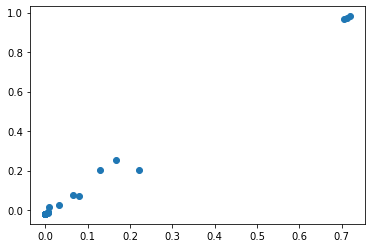

In [68]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')
from sagemaker.predictor import csv_serializer, json_deserializer
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

result = linear_regressor.predict(X)
result
predictions = np.array([res['score'] for res in result['predictions']])
predictions #should now be an numpy array

#Visualize how accurate predictions are relative to y_test
plt.scatter(y, predictions)

In [69]:
result

{'predictions': [{'score': 0.9814669489860535},
  {'score': -0.011907544918358326},
  {'score': 0.974168598651886},
  {'score': -0.01280759647488594},
  {'score': 0.9677703976631165},
  {'score': 0.25176018476486206},
  {'score': 0.20243382453918457},
  {'score': 0.07638408988714218},
  {'score': 0.07026105374097824},
  {'score': -0.01920587569475174},
  {'score': 0.20095738768577576},
  {'score': -0.01920587569475174},
  {'score': 0.02723059058189392},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01920587569475174},
  {'score': -0.01

In [70]:
#coeficientes en np
predictions

array([ 0.98146695, -0.01190754,  0.9741686 , -0.0128076 ,  0.9677704 ,
        0.25176018,  0.20243382,  0.07638409,  0.07026105, -0.01920588,
        0.20095739, -0.01920588,  0.02723059, -0.01920588, -0.01920588,
       -0.01920588, -0.01920588, -0.01920588, -0.01920588, -0.01920588,
       -0.01920588, -0.01920588, -0.01920588, -0.01920588, -0.01920588,
       -0.01920588, -0.01920588, -0.01920588, -0.01202229,  0.01632439])

In [71]:
#un cálculo para medir el triste accuracy de nuestra predicción
prediction_accuracy= np.mean((y-- predictions))*100

In [72]:
prediction_accuracy

20.880902935750782

In [ ]:
#predictions.sum()

Ahora podemos ver los resultados que hemos predicho en nuestro modelo. Deshacemos la normalización volviendo a multiplicar por el censo de Zaragoza, y lo almacenamos en un df.

In [73]:
estimacion= predictions*censo_mod
estimacion

array([702129.67770123,  -8518.51474405, 696908.52545238,  -9162.40082698,
       692331.32924342, 180106.21505857, 144818.72886944,  54644.26129618,
        50263.91471365, -13739.65300152, 143762.50366175, -13739.65300152,
        19480.4377352 , -13739.65300152, -13739.65300152, -13739.65300152,
       -13739.65300152, -13739.65300152, -13739.65300152, -13739.65300152,
       -13739.65300152, -13739.65300152, -13739.65300152, -13739.65300152,
       -13739.65300152, -13739.65300152, -13739.65300152, -13739.65300152,
        -8600.60493454,  11678.27251725])

In [74]:
df_estim = pd.DataFrame(estimacion, index = secciones_select_norm.index, columns = ['Estimación']).astype('int32')

In [75]:
df_estim

,Estimación
Votos_Total,702129
Nulos,-8518
Votos_Válidos,696908
Blanco,-9162
V_Cand,692331
PP,180106
PSOE,144818
Cs,54644
UP,50263
IU,-13739


Ahora mostramos los datos reales que queríamos modelizar, y lo mostramos en otro df.

In [76]:
df1 = pd.DataFrame(secciones_mod.sum(), columns = ['Real']).drop('Censo_Esc')

In [77]:
df1

,Real
Votos_Total,514697
Nulos,4347
Votos_Válidos,510350
Blanco,4978
V_Cand,505372
PP,119421
PSOE,157420
Cs,46645
UP,57398
IU,0


Comparamos ambos df. Nada que ver con el modelo entrenado en local. 

In [78]:
df_estim['Real'] = df1['Real']

In [79]:
df_estim

,Estimación,Real
Votos_Total,702129,514697
Nulos,-8518,4347
Votos_Válidos,696908,510350
Blanco,-9162,4978
V_Cand,692331,505372
PP,180106,119421
PSOE,144818,157420
Cs,54644,46645
UP,50263,57398
IU,-13739,0


In [80]:
df_estim.to_csv('estimacion-real-sm-lm.csv')

Para comprobar la efectividad del modelo con el dataset de 2016 como se hace en el notebook de modelización elaborado de manera local, aquí podríamos probar un batch transform, pero como el resultado ha sido muy malo en training con 2019 no continuamos.